# Aerosol profile validation

> Authors: Alexander Geiss with data from Holger Baars (TROPOS)
>
> Abstract: Comparing ground-based aerosol lidar measurements with Aeolus L2A data.

## Load packages, modules and extensions  
Note the line for interactive plotting function!

In [1]:
# enable following line for interactive visualization backend for matplotlib
# %matplotlib widget
# print version info
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.18.0

viresclient: 0.11.3
pandas     : 2.1.3
xarray     : 2023.12.0
matplotlib : 3.8.2



In [2]:
from viresclient import AeolusRequest
import numpy as np
import netCDF4 as nc
import xarray as xr
import os
from ftplib import FTP_TLS
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as feature
import cartopy.geodesic as geodesic
from geopy import distance

## Download ground-based aerosol lidar data (PollyXT from TROPOS, https://polly.tropos.de/)

Example data is stored on the Aeolus CAL/VAL FTP-Server (for details, see: https://www.aeolus.esa.int/confluence/display/CALVAL/Calval+Ftp).  
We will first download data for a case above Leipzig, Germany, where a Saharan dust layer could be observed on 8 November 2020.

In [3]:
# Define folder on FTP
folder_name = "TROPOS_Saharan_Dust_in_Leipzig_Nov_2020"
# File names on FTP
filenames = [
    "2020_11_08_Sun_TROPOS_00_00_01_att_bsc.nc",
    "2020_11_08_Sun_TROPOS_00_00_01_0500_0559_profiles.nc",
]

# Get user folder and set/create folder for example files
user_folder = os.path.expanduser("~")
example_folder = os.path.join(user_folder, f"files/examples/ground-based/aerosol/{folder_name}")
os.makedirs(example_folder, exist_ok=True)
# Set list of file paths
file_paths = [example_folder + "/" + i for i in filenames]

In [4]:
# Set user and password from Aeolus CAL/VAL FTP credentials (see above)
USERNAME = os.environ["CALVALU"]
PW = os.environ["CALVALP"]
# Uncomment following two lines and comment the two lines above to provide your credentials as input
# USERNAME = "xxxx"
# PW = "xxxx"

# Connect to the Cal/Val FTP server
ftps = FTP_TLS("ftp.eopp.esa.int")
ftps.login(user=USERNAME, passwd=PW)
ftps.prot_p()

# change directory
ftps.cwd(f"/aeolus_calval/aerosol_case_studies/{folder_name}/")

# Download example files to user space
for file_path, filename in zip(file_paths, filenames):
    if not os.path.isfile(file_path):
        with open(file_path, "wb") as fp:
            ftps.retrbinary("RETR " + filename, fp.write, blocksize=262144)

# close FTP connection
ftps.quit()

'221 Goodbye.'

## Load netCDF data and prepare data for comparison

Load saved ground-based lidar data from netCDF

In [5]:
pollyXT_attbsc = xr.load_dataset(file_paths[0])
pollyXT_profiles = xr.load_dataset(file_paths[1])

Add datetime representation for time variables/coordinates

In [6]:
pollyXT_attbsc["datetime"] = nc.num2date(
    pollyXT_attbsc["time"], units=pollyXT_attbsc["time"].unit, only_use_cftime_datetimes=False
)
pollyXT_profiles["start_datetime"] = (
    ("method"),
    nc.num2date(
        pollyXT_profiles["start_time"],
        units=pollyXT_profiles["start_time"].unit,
        only_use_cftime_datetimes=False,
    ),
)
pollyXT_profiles["end_datetime"] = (
    ("method"),
    nc.num2date(
        pollyXT_profiles["end_time"],
        units=pollyXT_profiles["end_time"].unit,
        only_use_cftime_datetimes=False,
    ),
)

### Convert particle backscatter coefficient to Aeolus co-polar particle backscatter coefficient

Aeolus emits circular polarized light which is then scattered at particles in the atmosphere and only the backscattered light is captured by the telescope where only the co-polar component is measured.  
To compare ground-based lidar measurements based on linear polarized light with Aeolus, we have to take into account the polarization as well as only the co-polar component.  
Following equations can be used to convert the linear depolarizaton ratio to circular depolarization ratio which can be used to calculate the co-polar part of the ground-based particle backscatter coefficient:

$$\delta_{lin} = \frac{\beta_{cross}}{\beta_{co}}$$

$$\delta_{circ} = \frac{2\delta_{lin}}{1-\delta_{lin}}$$

$$S_{co} = S(\delta_{circ}+1)$$

$$\beta_{co} = \frac{\beta_{tot}}{(\delta_{circ}+1)}$$

In [7]:
# calculate circular depolarization ratio
parDepol_raman_355_circ = (
    2 * pollyXT_profiles["parDepol_raman_355"] / (1 - pollyXT_profiles["parDepol_raman_355"])
)

# calculate co-polar particle backscatter coefficient component
aerBsc_raman_355_copolar = pollyXT_profiles["aerBsc_raman_355"] / (1 + parDepol_raman_355_circ)

# calculate co-polar aerosol lidar ratio
aerLR_raman_355_copolar = pollyXT_profiles["aerLR_raman_355"] * (1 + parDepol_raman_355_circ)

# Add both paramters to the xarray dataset
pollyXT_profiles["parDepol_raman_355_circ"] = (("height"), parDepol_raman_355_circ.data)
pollyXT_profiles["aerBsc_raman_355_copolar"] = (("height"), aerBsc_raman_355_copolar.data)
pollyXT_profiles["aerLR_raman_355_copolar"] = (("height"), aerLR_raman_355_copolar.data)

In [8]:
# PollyXT height is given above ground level.
# For comparison with Aeolus we have to calculate height above sea level in km by adding the station altitude.
pollyXT_profiles["height_asl_km"] = (
    ("height"),
    (pollyXT_profiles["height"].data + pollyXT_profiles["altitude"].data) / 1000,
)

Plot ground-site data products of interest for Aeolus validation.  
Note that a rolling median is applied to the profile data to smooth the curves.

Text(0.5, 0.98, 'PollyXT measurement at 355 nm averaged from 2020-11-08T05:00:00 until 2020-11-08T05:59:30')

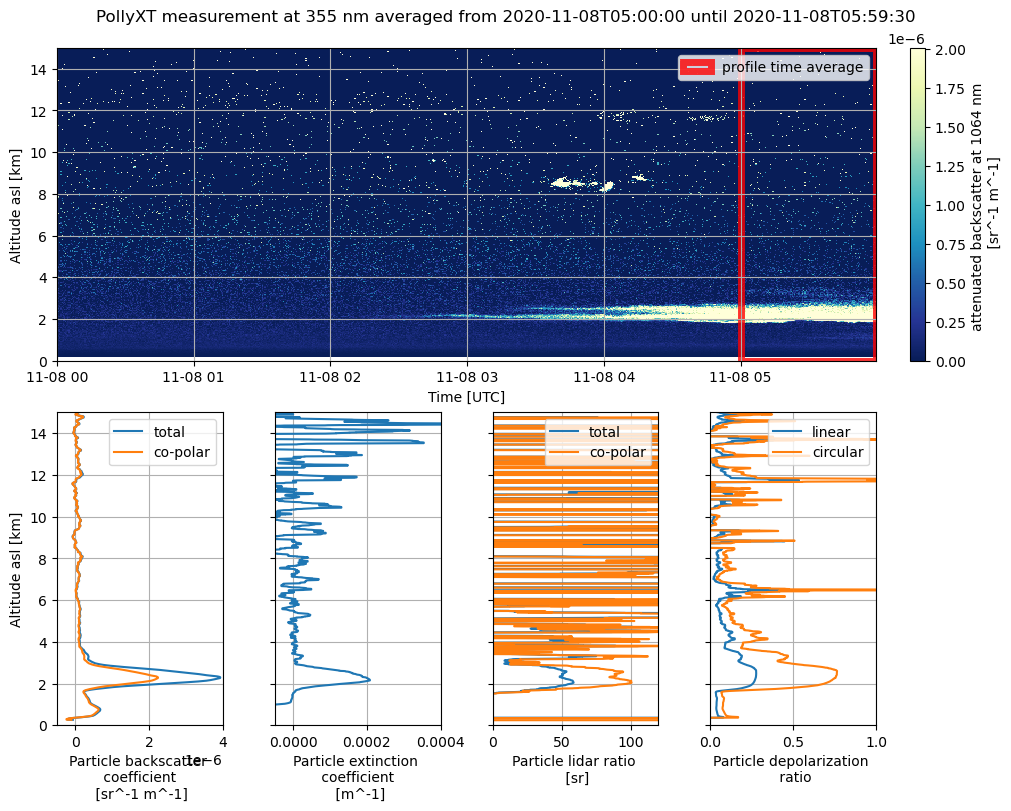

In [9]:
fig = plt.figure(figsize=(10, 8), constrained_layout=True)  # , constrained_layout=True)
ax = []
gs = fig.add_gridspec(2, 4)
ax.append(fig.add_subplot(gs[1, 0]))
ax.append(fig.add_subplot(gs[1, 1], sharey=ax[0]))
ax.append(fig.add_subplot(gs[1, 2], sharey=ax[0]))
ax.append(fig.add_subplot(gs[1, 3], sharey=ax[0]))
ax.append(fig.add_subplot(gs[0, :]))

ax[0].plot(
    pollyXT_profiles["aerBsc_raman_355"].rolling(height=9).median(),
    pollyXT_profiles["height_asl_km"],
    label="total",
)
ax[0].plot(
    pollyXT_profiles["aerBsc_raman_355_copolar"].rolling(height=9).median(),
    pollyXT_profiles["height_asl_km"],
    label="co-polar",
)
ax[0].set_ylim(0, 15)
ax[0].set_xlim(-0.5e-6, 4e-6)
ax[0].set_ylabel("Altitude asl [km]")
ax[0].set_xlabel(
    "Particle backscatter \n coefficient \n [{}]".format(pollyXT_profiles["aerBsc_raman_355"].unit)
)
ax[0].legend(loc="upper right")

ax[1].plot(
    pollyXT_profiles["aerExt_raman_355"].rolling(height=9).median(),
    pollyXT_profiles["height_asl_km"],
)
ax[1].set_xlabel(
    "Particle extinction \n coefficient \n [{}]".format(pollyXT_profiles["aerExt_raman_355"].unit)
)
ax[1].set_xlim(-0.5e-4, 4e-4)
ax[1].tick_params(labelleft=False)

ax[2].plot(
    pollyXT_profiles["aerLR_raman_355"].rolling(height=9).median(),
    pollyXT_profiles["height_asl_km"],
    label="total",
)
ax[2].plot(
    pollyXT_profiles["aerLR_raman_355_copolar"].rolling(height=5).median(),
    pollyXT_profiles["height_asl_km"],
    label="co-polar",
)
ax[2].set_xlabel("Particle lidar ratio \n [{}]".format(pollyXT_profiles["aerLR_raman_355"].unit))
ax[2].set_xlim(0, 120)
ax[2].tick_params(labelleft=False)
ax[2].legend(loc="upper right")

ax[3].plot(
    pollyXT_profiles["parDepol_raman_355"].rolling(height=9).median(),
    pollyXT_profiles["height_asl_km"],
    label="linear",
)
ax[3].plot(
    pollyXT_profiles["parDepol_raman_355_circ"].rolling(height=9).median(),
    pollyXT_profiles["height_asl_km"],
    label="circular",
)
ax[3].set_xlabel("Particle depolarization \n ratio")
ax[3].set_xlim(0, 1.0)
ax[3].tick_params(labelleft=False)
ax[3].legend(loc="upper right")

img = ax[4].pcolormesh(
    pollyXT_attbsc["datetime"].values,
    (pollyXT_attbsc["height"].values + pollyXT_attbsc["altitude"].values) / 1000,
    pollyXT_attbsc["attenuated_backscatter_1064nm"].values[:-1, :-1].T,
    vmin=0,
    vmax=np.percentile(pollyXT_attbsc["attenuated_backscatter_1064nm"].values, 99),
    cmap="YlGnBu_r",
)
ax[4].axvspan(
    pollyXT_profiles["start_datetime"][0].values,
    pollyXT_profiles["end_datetime"][0].values,
    alpha=0.8,
    label="profile time average",
    ec='r',
    fill=False,
    lw=5
)
ax[4].set_ylabel("Altitude asl [km]")
ax[4].set_ylim(0, 15)
ax[4].set_xlabel("Time [UTC]")
ax[4].legend(loc="upper right")

fig.colorbar(
    img,
    ax=ax[4],
    aspect=20,
    pad=0.0001,
    label="{} \n [{}]".format(
        pollyXT_attbsc["attenuated_backscatter_1064nm"].long_name,
        pollyXT_attbsc["attenuated_backscatter_1064nm"].unit,
    ),
)

for axis in ax:
    axis.grid()

fig.suptitle(
    "PollyXT measurement at 355 nm averaged from {} until {}".format(
        pollyXT_profiles["start_datetime"][0].values.astype("datetime64[s]"),
        pollyXT_profiles["end_datetime"][0].values.astype("datetime64[s]"),
    )
)

In the ground-based lidar data we can see a strong aerosol layer at around 2 km altitude starting at 03:00 UTC.  
Now, let's see if Aeolus could capture this aerosol layer as well.

## Retrieve Aeolus data for the ground-site geolocation and measurement time

In [10]:
# get location and time-range from ground-based lidar data
# latitude and longitude in the data is swapped, so we need to correct for this.
longitude_collocated = float(pollyXT_attbsc["latitude"].values)
latitude_collocated = float(pollyXT_attbsc["longitude"].values)
time_collocated_min = (
    pollyXT_attbsc["datetime"]
    .min()
    .values.astype("datetime64[s]")
)
time_collocated_max = (
    pollyXT_attbsc["datetime"]
    .max()
    .values.astype("datetime64[s]")
)

/tmp/ipykernel_1702/1621349645.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  longitude_collocated = float(pollyXT_attbsc["latitude"].values)
/tmp/ipykernel_1702/1621349645.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  latitude_collocated = float(pollyXT_attbsc["longitude"].values)


In [11]:
# measurement period in yyyy-mm-ddTHH:MM:SS
measurement_start = str(time_collocated_min)
measurement_stop = str(time_collocated_max)

In [12]:
parameter_observation = [
    "L1B_start_time_obs",
    "L1B_centroid_time_obs",
    "longitude_of_DEM_intersection_obs",
    "latitude_of_DEM_intersection_obs",
    "altitude_of_DEM_intersection_obs",
    "rayleigh_altitude_obs",
    "sca_mask",
]

parameter_sca = [
    "SCA_time_obs",
    "SCA_middle_bin_altitude_obs",
    "SCA_QC_flag",
    "SCA_processing_qc_flag",
    "SCA_middle_bin_processing_qc_flag",
    "SCA_extinction",
    "SCA_extinction_variance",
    "SCA_backscatter",
    "SCA_backscatter_variance",
    "SCA_LOD",
    "SCA_LOD_variance",
    "SCA_middle_bin_extinction",
    "SCA_middle_bin_extinction_variance",
    "SCA_middle_bin_backscatter",
    "SCA_middle_bin_backscatter_variance",
    "SCA_middle_bin_LOD",
    "SCA_middle_bin_LOD_variance",
    "SCA_middle_bin_BER",
    "SCA_middle_bin_BER_variance",
    "SCA_SR",
]

In [13]:
# Data request for SCA aerosol product
request = AeolusRequest()

request.set_collection("ALD_U_N_2A")

# set observation fields
request.set_fields(
    observation_fields=parameter_observation,
)

# set SCA fields
request.set_fields(
    sca_fields=parameter_sca,
)

# Set bounding box for the area around the ground-site geolocation
request.set_bbox(
    {
        "n": latitude_collocated + 2,
        "w": longitude_collocated - 2,
        "s": latitude_collocated - 2,
        "e": longitude_collocated + 2,
    }
)

# set start and end time and request data
data_sca = request.get_between(
    start_time=measurement_start, end_time=measurement_stop, filetype="nc", asynchronous=True
)

# Save data as xarray data set
ds_sca_preliminary = data_sca.as_xarray()

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.115MB)

In [14]:
# Data request for SCA aerosol product
request = AeolusRequest()

request.set_collection("ALD_U_N_1B")

# set observation fields
request.set_fields(
    observation_fields=["rayleigh_SNR", "mie_SNR", "rayleigh_altitude", "mie_altitude", "time"],
)

# Set bounding box for the area around the ground-site geolocation
request.set_bbox(
    {
        "n": latitude_collocated + 2,
        "w": longitude_collocated - 2,
        "s": latitude_collocated - 2,
        "e": longitude_collocated + 2,
    }
)

# set start and end time and request data
data_L1B = request.get_between(
    start_time=measurement_start, end_time=measurement_stop, filetype="nc", asynchronous=True
)

# Save data as xarray data set
ds_L1B = data_L1B.as_xarray()

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.027MB)

The following processing is already shown and explained in the Demo_ALD_U_N_2A jupyter notebook.  
### Remove duplicate profiles in L2A product
Especially at the border of two L2A raw data files, duplicates can be present. These must be removed by using the time parameters.
It can happen that they are also present in data which is retrieved from the VirES server.

In [15]:
# Create mask of unique profiles
_, unique_mask = np.unique(ds_sca_preliminary["SCA_time_obs"], return_index=True)

# Create new dataset and fill in L2A dataset variables with applied unique_mask
ds_sca = xr.Dataset()
for param in ds_sca_preliminary.keys():
    ds_sca[param] = (
        ds_sca_preliminary[param].dims,
        ds_sca_preliminary[param].data[unique_mask],
        ds_sca_preliminary[param].attrs,
    )
del ds_sca_preliminary

### Add datetime variable to the data sets

In [16]:
ds_sca["SCA_time_obs_datetime"] = (
    ("sca_dim"),
    nc.num2date(
        ds_sca["SCA_time_obs"], units="s since 2000-01-01", only_use_cftime_datetimes=False
    ),
)

ds_sca["L1B_start_time_obs_datetime"] = (
    ("observation"),
    nc.num2date(
        ds_sca["L1B_start_time_obs"], units="s since 2000-01-01", only_use_cftime_datetimes=False
    ),
)

ds_sca["L1B_centroid_time_obs_datetime"] = (
    ("observation"),
    nc.num2date(
        ds_sca["L1B_centroid_time_obs"], units="s since 2000-01-01", only_use_cftime_datetimes=False
    ),
)

ds_L1B["datetime"] = (
    ("observation"),
    nc.num2date(ds_L1B["time"], units="s since 2000-01-01", only_use_cftime_datetimes=False),
)

### Extract bits from processing_qc_flag and add them to the data sets for QC

In [17]:
ds_sca["SCA_validity_flags"] = (
    ("sca_dim", "array_24", "array_8"),
    np.unpackbits(
        ds_sca["SCA_processing_qc_flag"][:, :].values.view(np.uint8), bitorder="little"
    ).reshape([-1, 24, 8]),
)
ds_sca["SCA_middle_bin_validity_flags"] = (
    ("sca_dim", "array_23", "array_8"),
    np.unpackbits(
        ds_sca["SCA_middle_bin_processing_qc_flag"][:, :].values.view(np.uint8), bitorder="little"
    ).reshape([-1, 23, 8]),
)

### Add SCA/SCA-mid-bin geolocation and SCA altitude 

In [18]:
# SCA altitude
ds_sca["SCA_bin_altitude_obs"] = (
    ("sca_dim", "array_25"),
    ds_sca["rayleigh_altitude_obs"][ds_sca["sca_mask"].astype(bool)].data,
)
# SCA and SCA-mid-bin longitude
ds_sca["SCA_longitude"] = (
    ("sca_dim"),
    ds_sca["longitude_of_DEM_intersection_obs"][ds_sca["sca_mask"].astype(bool)].data,
)
# SCA and SCA-mid-bin latitude
ds_sca["SCA_latitude"] = (
    ("sca_dim"),
    ds_sca["latitude_of_DEM_intersection_obs"][ds_sca["sca_mask"].astype(bool)].data,
)

### Add SCA/SCA-mid-bin altitude for CoG
Altitude are given for the range bin boundaries but center altitude are needed for profile plots.

In [19]:
# SCA altitude for range bin center
ds_sca["SCA_bin_altitude_center_obs"] = (
    ("sca_dim", "array_24"),
    ds_sca["SCA_bin_altitude_obs"][:, 1:].data
    - ds_sca["SCA_bin_altitude_obs"].diff(dim="array_25").data / 2.0,
)

# SCA mid-bin altitude for range bin center
ds_sca["SCA_middle_bin_altitude_center_obs"] = (
    ("sca_dim", "array_23"),
    ds_sca["SCA_middle_bin_altitude_obs"][:, 1:].data
    - ds_sca["SCA_middle_bin_altitude_obs"].diff(dim="array_24").data / 2.0,
)

### Add lidar ratio
Lidar ratio is just the inverse of the backscatter to extinction ratio (BER)

In [20]:
ds_sca["SCA_middle_bin_lidar_ratio"] = (
    ("sca_dim", "array_23"),
    1.0 / ds_sca["SCA_middle_bin_BER"].data,
)

### Add L1B_SNR to SCA dataset
L1B SNR can be used as the main proxy for QC-filtering.

In [21]:
# SNR for SCA
rayleigh_SNR = ds_L1B["rayleigh_SNR"][:, :-1][ds_sca["sca_mask"].astype(bool)].data
ds_sca["SCA_rayleigh_SNR"] = (
    ("sca_dim", "array_24"),
    rayleigh_SNR,
)
mie_SNR = ds_L1B["mie_SNR"][:, :-1][ds_sca["sca_mask"].astype(bool)].data
ds_sca["SCA_mie_SNR"] = (
    ("sca_dim", "array_24"),
    mie_SNR,
)

# SNR for SCA_middle_bin
rayleigh_SNR_mid_bin = (rayleigh_SNR[:, :-1] + rayleigh_SNR[:, 1:]) / 2.0
ds_sca["SCA_middle_bin_rayleigh_SNR"] = (
    ("sca_dim", "array_23"),
    rayleigh_SNR_mid_bin,
)
mie_SNR_mid_bin = (mie_SNR[:, :-1] + mie_SNR[:, 1:]) / 2.0
ds_sca["SCA_middle_bin_mie_SNR"] = (
    ("sca_dim", "array_23"),
    mie_SNR_mid_bin,
)

### Scale backscatter and extinction with 1e-6
Backscatter and extinction values in the L2A product are scaled with 1e-6.

In [22]:
for parameter in [
    "SCA_extinction",
    "SCA_backscatter",
    "SCA_middle_bin_extinction",
    "SCA_middle_bin_backscatter",
]:
    ds_sca[parameter] *= 1e-6

## Plot overview map of ground-site and collocated Aeolus measurements

Text(0.5, 1.0, 'Aeolus orbit \n from 2020-11-08T05:27:23 to 2020-11-08T05:28:11')

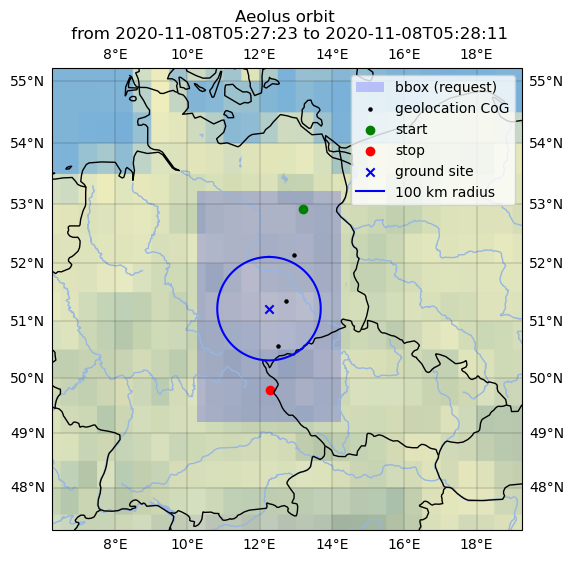

In [23]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=longitude_collocated))
ax.set_extent(
    [
        longitude_collocated - 6,
        longitude_collocated + 7,
        latitude_collocated - 4,
        latitude_collocated + 4,
    ],
    crs=ccrs.PlateCarree(),
)
ax.stock_img()
ax.add_feature(feature.LAKES)
ax.add_feature(feature.RIVERS, linestyle="-")
ax.add_feature(feature.BORDERS.with_scale("50m"), linestyle="-")
ax.coastlines(resolution="50m")
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="-")

ax.add_patch(
    Rectangle(
        xy=[longitude_collocated - 2, latitude_collocated - 2],
        width=4,
        height=4,
        facecolor="blue",
        alpha=0.2,
        transform=ccrs.PlateCarree(),
        label="bbox (request)",
    )
)

ax.scatter(
    ds_sca["longitude_of_DEM_intersection_obs"],
    ds_sca["latitude_of_DEM_intersection_obs"],
    marker="o",
    c="k",
    s=5,
    label="geolocation CoG",
    transform=ccrs.Geodetic(),
)
ax.scatter(
    ds_sca["longitude_of_DEM_intersection_obs"][0],
    ds_sca["latitude_of_DEM_intersection_obs"][0],
    marker="o",
    c="g",
    edgecolor="g",
    label="start",
    transform=ccrs.Geodetic(),
)
ax.scatter(
    ds_sca["longitude_of_DEM_intersection_obs"][-1],
    ds_sca["latitude_of_DEM_intersection_obs"][-1],
    marker="o",
    c="r",
    edgecolor="r",
    label="stop",
    transform=ccrs.Geodetic(),
)
ax.scatter(
    longitude_collocated,
    latitude_collocated,
    marker="x",
    c="b",
    # edgecolor="b",
    label="ground site",
    transform=ccrs.Geodetic(),
)

circle = geodesic.Geodesic().circle(longitude_collocated, latitude_collocated, 100000, 180, True)
ax.plot(circle[:, 0], circle[:, 1], "b-", transform=ccrs.Geodetic(), label="100 km radius")

ax.legend()
ax.set_title(
    "Aeolus orbit \n from {} to {}".format(
        ds_sca["SCA_time_obs_datetime"][0].values.astype("datetime64[s]"),
        ds_sca["SCA_time_obs_datetime"][-1].values.astype("datetime64[s]"),
    )
)

In [24]:
# calculate distance to ground site from L2A obs center and save to list
dist_to_site = [
    int(distance.distance((latitude_collocated, longitude_collocated), (i, j)).km)
    for i, j in zip(
        ds_sca["latitude_of_DEM_intersection_obs"], ds_sca["longitude_of_DEM_intersection_obs"]
    )
]

## Compare profiles from Aeolus and ground-site

In [25]:
def plot_profile_comparison(i):
    """
    Function for Aeolus L2A with ground-based PollyXT data

    Parameters
    ----------
    i : 'int'
        id of the L2A profile to plot (see map plot above for geolocation)
    """

    if i > (ds_sca.dims["observation"] - 1):
        print(f"maximum profile_id is {ds_sca.dims['observation']-1}")
    else:
        fig, ax = plt.subplots(1, 5, figsize=(13, 5), sharey=True, constrained_layout=True)

        ax[0].plot(
            pollyXT_profiles["aerBsc_raman_355"].rolling(height=9).median(),
            pollyXT_profiles["height_asl_km"],
            label="PollyXT total",
        )
        ax[0].plot(
            pollyXT_profiles["aerBsc_raman_355_copolar"].rolling(height=9).median(),
            pollyXT_profiles["height_asl_km"],
            label="PollyXT co-polar",
        )
        # In the following subplots we don't plot the first SCA_middle_bin, because its altitude is always -1
        ax[0].plot(
            ds_sca["SCA_middle_bin_backscatter"][i, 1:],
            ds_sca["SCA_middle_bin_altitude_center_obs"][i, 1:] / 1000.0,
            label="SCA_middle_bin",
        )

        ax[0].set_ylim(0, 15)
        ax[0].set_xlim(-0.5e-6, 4e-6)
        ax[0].set_ylabel("Altitude asl [km]")
        ax[0].set_xlabel(
            "Particle backscatter \n coefficient \n [{}]".format(
                pollyXT_profiles["aerBsc_raman_355"].unit
            )
        )
        ax[0].legend(loc="upper right")

        ax[1].plot(
            pollyXT_profiles["aerExt_raman_355"].rolling(height=9).median(),
            pollyXT_profiles["height_asl_km"],
            label="PollyXT",
        )
        ax[1].plot(
            ds_sca["SCA_middle_bin_extinction"][i, 1:],
            ds_sca["SCA_middle_bin_altitude_center_obs"][i, 1:] / 1000.0,
            label="SCA_middle_bin",
        )

        ax[1].set_xlabel(
            "Particle extinction \n coefficient \n [{}]".format(
                pollyXT_profiles["aerExt_raman_355"].unit
            )
        )
        ax[1].set_xlim(-0.5e-4, 4e-4)
        ax[1].tick_params(labelleft=False)
        ax[1].legend(loc="upper right")

        ax[2].plot(
            pollyXT_profiles["aerLR_raman_355"].rolling(height=9).median(),
            pollyXT_profiles["height_asl_km"],
            label="PollyXT total",
        )
        ax[2].plot(
            pollyXT_profiles["aerLR_raman_355_copolar"].rolling(height=5).median(),
            pollyXT_profiles["height_asl_km"],
            label="PollyXT co-polar",
        )
        ax[2].plot(
            ds_sca["SCA_middle_bin_lidar_ratio"][i, 1:],
            ds_sca["SCA_middle_bin_altitude_center_obs"][i, 1:] / 1000.0,
            label="SCA_middle_bin",
        )

        ax[2].set_xlabel(
            "Particle lidar ratio \n [{}]".format(pollyXT_profiles["aerLR_raman_355"].unit)
        )
        ax[2].set_xlim(0, 150)
        ax[2].tick_params(labelleft=False)
        ax[2].legend(loc="upper right")

        ax[3].plot(
            ds_sca["SCA_middle_bin_rayleigh_SNR"][i, 1:],
            ds_sca["SCA_middle_bin_altitude_center_obs"][i, 1:] / 1000.0,
            label="Rayleigh",
        )
        ax[3].plot(
            ds_sca["SCA_middle_bin_mie_SNR"][i, 1:],
            ds_sca["SCA_middle_bin_altitude_center_obs"][i, 1:] / 1000.0,
            label="Mie",
        )
        ax[3].set_xlabel("SNR")
        ax[3].set_xlim(0, 220)
        ax[3].tick_params(labelleft=False)
        ax[3].legend(loc="upper right")

        # validity_flag[:, :, 0] == 0
        ax[4].plot(
            ds_sca["SCA_middle_bin_validity_flags"][i, 1:, 0],
            ds_sca["SCA_middle_bin_altitude_center_obs"][i, 1:] / 1000.0,
            label="SCA_mid_bin_extinction",
        )
        ax[4].plot(
            ds_sca["SCA_middle_bin_validity_flags"][i, 1:, 1],
            ds_sca["SCA_middle_bin_altitude_center_obs"][i, 1:] / 1000.0,
            label="SCA_mid_bin_backscatter",
        )
        ax[4].set_xlabel("Validity flag")
        ax[4].set_xticks([0, 1], ["invalid", "valid"])
        ax[4].tick_params(labelleft=False)
        ax[4].legend(loc="upper right")

        fig.suptitle(
            "Aeolus observation at {} latitude - {} longitude \n".format(
                ds_sca["latitude_of_DEM_intersection_obs"][i].values.round(2),
                ds_sca["longitude_of_DEM_intersection_obs"][i].values.round(2),
            )
            + "at {} \n Distance between ground-site and obs center: {} km".format(
                ds_sca["SCA_time_obs_datetime"][i].values.astype("datetime64[s]"),
                dist_to_site[i],
            )
        )
        for axis in ax:
            axis.grid()

Plot profile number 2 (check geolocation in the plot above)

/opt/conda/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


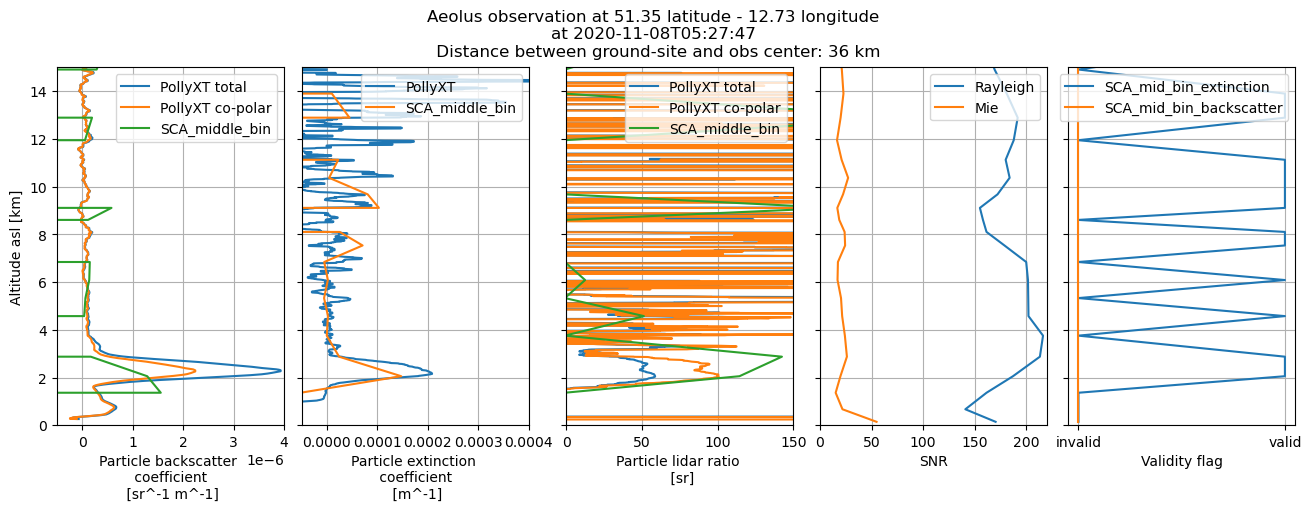

In [26]:
plot_profile_comparison(2)

Plot profile number 1

/opt/conda/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


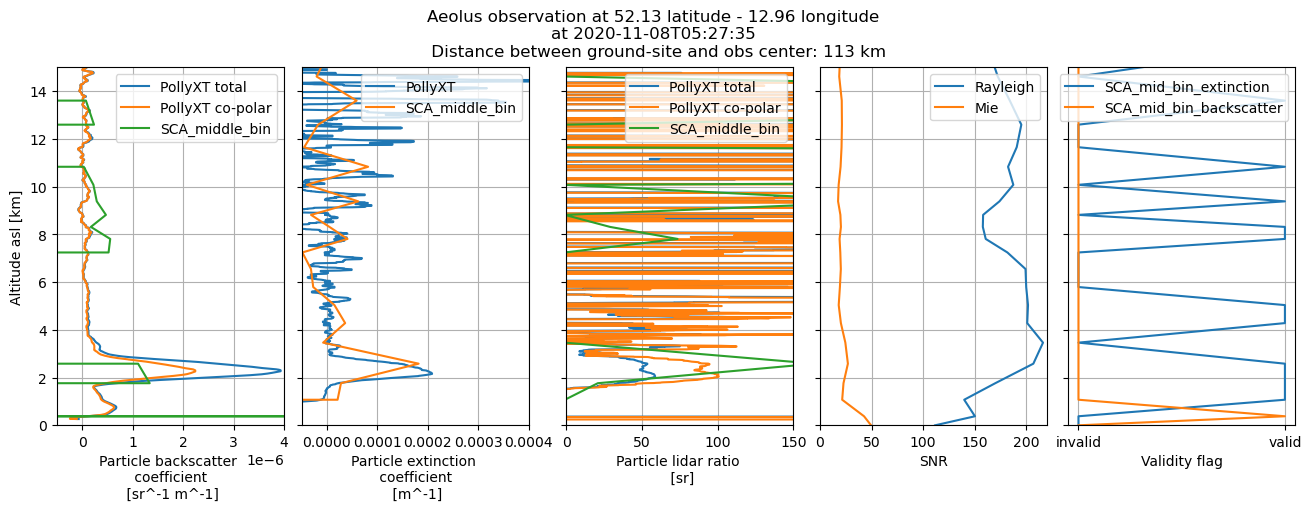

In [27]:
plot_profile_comparison(1)